# Building an MCMC library on PyTorch

Way back in the year 2015 I discovered Bayesian statistics and immediately fell in love. At the time I found a lot of use for Bayesian models in my research. However, the Python libraries built for Bayesian data analysis were difficult to use for my purposes. So, as any good postdoc will do, I spent a couple months building my own library, [Sampyl](https://github.com/mcleonard/sampyl). A bit after that, I got a job at Udacity teaching various data science topics and unfortunately stopped developing Sampyl as I wasn't using it on a daily basis.

Fast forward a bit and I'm teaching deep learning at Udacity. Initially we used TensorFlow as it was by far the most used and useable deep learning framework available. However, PyTorch was released in mid-2017 and it was a revelation. Again, I immediately fell in love. Building neural networks wasn't just easy, it was *fun*. PyTorch is a wonderful library, built as a natural extension of Python and Numpy. It comes with a suite of numerical optimizers and calculates gradients automatically. Turns out, these exact features make it an excellent choice as a backend for Bayesian data analysis libraries. 

Here is my initial work building a library for Bayesian data analysis using PyTorch. Currently it's just a Jupyter notebook, but it's a simple step to migrate the code here to a proper Python library. You can find this notebook along with [my other blog posts here](https://github.com/mcleonard/blog_posts/blob/master/PyTorch-MCMC.ipynb).

## Setting up the problem

Suppose we have samples from two groups and we'd like to know if there is some effect between the two groups. A common example is drug trials. We have a control and treatment group which get a placebo and the actual drug, respectively. Then, we want to know if taking the drug results in some actual effect. Typically you would do something like a t-test here where we're asking if the means of the two samples are the same (our null hypothesis). The t-test gives us a p-value which we can use to judge if an effect we see is real, rather than a random fluctuation.

I prefer coming at this problem from a Bayesian perspective. Instead of a single statistic like the p-value, we get a *distribution* over our model parameters called the posterior. This posterior distribution tells us the most likely values for the parameters. From the posterior distribution you can get point estimates such as means, and also measure the *uncertainty* in our parameters. You can use Bayesian models for inference as well. By sampling from the posterior, you get a distribution for infered values so you can directly measure the uncertainty in the predictions.

The drawback of Bayesian statistics is that in many cases the posterior distribution is analytically intractable, there is no way to calculate it by hand. Instead we use algorithms called Markov Chain Monte Carlo (MCMC) to sample from the posterior distribution. In Python, the best option is likely [PyMC3](https://docs.pymc.io/), an excellent and full-featured MCMC library. There is also a library I built called [Sampyl](https://github.com/mcleonard/sampyl), which is useful but also not as well maintained as PyMC3. I'm not going to go into much detail about Bayesian statistics or MCMC samplers here. If you want to know more, I suggest these as a great place to start:

+ Jake VanderPlas' great series of [articles on Bayesian statistics](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
+ [Probabilist Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) by Cam Davidson-Pilon

Time to get started. First I'll generate some data for us with a small effect size. 

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch

plt.style.use('seaborn')

In [2]:
np.random.seed(15)
group1 = (np.random.randn(20) + 0.3)
group2 = np.random.randn(20)

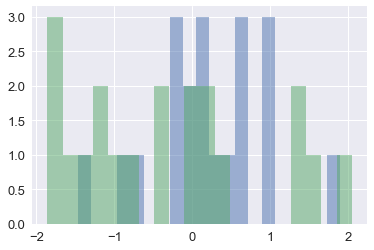

In [3]:
plt.hist(group1, alpha=0.5, bins=20)
plt.hist(group2, alpha=0.5, bins=20);
plt.savefig('/Users/mat/Desktop/test.png', dpi=200)

I'm going to create a couple classes specifically for this library that are subclassed from PyTorch tensors. This will allow us to extend the tensors for use in our library, but also take advantage of the PyTorch API.

In [4]:
class Data(torch.Tensor):
    @staticmethod
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls, *args, **kwargs)
    
    def __init__(self, x):
        super().__init__()
    
    @classmethod
    def zeros(cls, *sizes, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False):
        return cls(torch.zeros(*sizes, out=out, dtype=dtype, layout=layout, device=device))
    
    @classmethod
    def ones(cls, *sizes, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False):
        return cls(torch.ones(*sizes, out=out, dtype=dtype, layout=layout, device=device))
    
    def __repr__(self):
        return f"{self.__class__.__name__}{repr(self.data)[6:]}"

In [5]:
class Parameter(Data):
    
    def __init__(self, x):
        self.requires_grad = True

In [6]:
data1 = Data(group1)
data2 = Data(group2)
mu = Parameter.zeros(2)
sig = Parameter.ones(2)

Now create classes for distributions that we'll be using for priors and likelihoods. First a few helper functions.

In [7]:
from numbers import Number
inf = torch.tensor(np.inf)

def fails_constraints(*conditions):
    """ When defining log-probabilities, there are usually constraints where we need
        to return negative infinity. For example, the log-probability of the value 2
        of a uniform distribution with bounds {0, 1} is `-inf`.
    """
    for each in conditions:
        if not torch.all(each):
            return True
    else:
        return False


def num_to_tensor(x):
    """ Converts floats and ints into torch Tensor. Useful for simplifying the API. 
        We can pass in ints and floats as distribution parameters then convert them to 
        tensors for use in torch operations.
    """
    return Data([x]) if isinstance(x, Number) else x

Now to the distributions themselves. For our current problem we only need the normal distribution and the uniform distribution. I'll create a base class `Distribution` which we'll subclass into our separate distributions. The only thing we really need from these distributions is the log-probability for some value `x` (which can be a scalar or a vector). I'm only defining two distributions here but creating more is straightforward.

In [8]:
class Distribution:
    def logp(self):
        raise NotImplementedError
        
    def __call__(self):
        return self.logp().squeeze()

class Normal(Distribution):
    def __init__(self, x, mu=0., sig=1.):
        self.x = x
        self.mu = num_to_tensor(mu)
        self.sig = num_to_tensor(sig)

    def logp(self):
        if fails_constraints(self.sig >= 0):
            return -inf
        
        return torch.sum(-torch.log(self.sig) - (self.x - self.mu)**2/(2*self.sig**2))
    
    def __repr__(self):
        return f"Normal(mu={self.mu}, sigma={self.sig})"
    
class Uniform(Distribution):
    def __init__(self, x, low=0., high=1.):
        self.x = x
        self.low = num_to_tensor(low)
        self.high = num_to_tensor(high)

    def logp(self):
        if fails_constraints(self.x >= self.low, self.x <= self.high):
            return -inf
    
        size = 1
        for dim_size in self.x.shape:
            size *= dim_size

        return -size * torch.log(self.high - self.low)
    
    def __repr__(self):
        return f"Uniform(low={self.low}, high={self.high})"

In [9]:
normal = Normal(data1.view(4, -1), mu=torch.rand(4, 1), sig=2)
normal()

tensor(-15.6073)

In [10]:
uniform = Uniform(mu, -1, 1)
uniform()

tensor(-1.3863)

Now we're going to build a model for our problem. We'll use a simplified version of the [BEST (Bayesian estimation supersedes the t-test)](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf) model. First I'm going to define a base class for our models. Since a model should return a log-probability proportional to the posterior distribution, it is also a distribution and we can subclass from `Distribution`. Our models are going to have parameters, so I want to collect the parameters as we define them which I'll do with `__setattr__`. This way later we can easily loop through all the paramters in our model. 

In [11]:
class Model(Distribution):
    
    def __init__(self):
        self.parameters = {}
    
    def iter_params(self):
        """ Return a generator that yields two element tuples (name: String, param: Parameter)."""
        for name, param  in self.parameters.items():
            yield name, param
    
    def update(self, param_dict):
        """ Update parameters with a dictionary {name: param} """
        for name, param in param_dict.items():
            self.parameters[name][:] = param
        
    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self.parameters[name] = value
        
        super().__setattr__(name, value)

Here I'm defining our model itself. With this model we're assuming our data is drawn from two normal distributions. These distributions have parameters for the means and standard deviations, $\mu_i$ and $\sigma_i$ respectively, $i$ denoting the two groups. We need priors for our parameters, so we'll use a normal prior for $\mu_i$ and a uniform prior for $\sigma_i$. 

When the model is created, we'll store the data and define our parameters. Then we need to define the `logp` method for our model. This method should return a value for the log-probability of the posterior (actually something proportial to the posterior), given the current parameters and data. For the final result, we simply sum up the log-probabilities of the likelihoods and priors.

In [12]:
def dist_sum(*distributions):
    """ Returns the sums of the log-probabilities of an arbitrary number of Distributions """
    return sum(x.logp() for x in distributions)

class BEST(Model):
    def __init__(self, group1, group2):
        super().__init__()
        
        self.group1 = group1
        self.group2 = group2
        
        self.mu = Parameter([0., 0.])
        self.sigma = Parameter([1., 1.])
        
    def logp(self):
       
        # Log-likelihood
        llh1 = Normal(self.group1, mu=self.mu[0], sig=self.sigma[0])
        llh2 = Normal(self.group2, mu=self.mu[1], sig=self.sigma[1])
        
        # Priors
        prior_mu = Normal(self.mu, mu=0., sig=1.)
        prior_sig = Uniform(self.sigma, 0., 100.)
        
        return dist_sum(llh1, llh2, prior_mu, prior_sig)

In [13]:
model = BEST(data1, data2)
model()

tensor(-29.5552, grad_fn=<SqueezeBackward0>)

Now that we have a model and can calculate a log-probability proportional to the posterior distribution, we can start sampling. However, we need to give our sampler some parameters to start at. A good option for this is the maximum a posteriori estimate (MAP). This estimate is the parameters where the posterior distribution is maximized. The MAP estimate is useful in itself, you can think of it like fitting a model in frequentist statistics where you get point estimates for the parameters. But we're Bayesianists, so we don't want just point estimates, we want distributions.

Since we built this with PyTorch, we can use it's built-in optimizers to find the MAP parameters. If you've trained a neural network in PyTorch, this is exactly the same process. We'll calculate the log-probability from our model, negating it since we're maximizing instead of minimizing. Then we'll calculate the gradients for the parameter tensors with respect to the posterior probability and use those gradients to update the parameters. 

In [14]:
from torch import optim
def find_MAP(model, iters=2000):
    optimizer = optim.Adam((param for _, param in model.iter_params()), lr=0.003)
    for step in range(iters):
        optimizer.zero_grad()

        # minimize the negative log posterior
        logp = -model()
        logp.backward()
        optimizer.step()

In [15]:
find_MAP(model)
for name, param in model.iter_params():
    print(f"{name}:  {param}")

mu:  Parameter([ 0.2094, -0.3046])
sigma:  Parameter([0.7333, 1.1599])


We can compare these with the empirical means and standard deviations of our data.

In [16]:
print(f"Data means: {data1.mean():.4f}, {data2.mean():.4f}")
print(f"Data stds: {data1.std():.4f}, {data2.std():.4f}")

Data means: 0.2151, -0.3251
Data stds: 0.7523, 1.1898


We need somewhere to store our sampled parameters as we build the chain. A good strategy here is to intialize a 2d tensor with rows equal to the number of requested samples and one column for each parameter. As we sample from the posterior we can insert the samples into this tensor. I'm actually going to use a Numpy array for the chain data. This is because we'll want to do things like plot histograms of our posterior samples. Python plotting libraries such as matplotlib are built to work with Numpy, so for ease of use it's better if the chain is a Numpy array.

Often we'll want to group parameters together as a vector like we've done with `mu` and `sigma` in the BEST model.  A good way to accomodate this is to assign attributes to the chain which return the columns for a specific parameter. For example, `chain.mu` should give us the two columns for samples of `mu`.

The API for this will look like `Chain(1000, mu=2, sigma=2)` which would give us a chain of 1000 samples (1000 rows), and 4 columns. The first two columns are for `mu`, the second two are for `sigma`.

In [17]:
from collections import OrderedDict
class Chain:
    def __init__(self, samples, **kwargs):
        self.fields = OrderedDict()
        
        prev_size = 0
        for name, size in kwargs.items():
            self.fields.update({name:(prev_size, prev_size + size)})
            prev_size = size
            
        total_size = sum(size for size in kwargs.values())
        self.data = np.zeros((samples, total_size))
        
    def __getitem__(self, name):
        return self.data[name]
        
    def __setitem__(self, name, value):
        self.data[name] = value
        
    def __getattr__(self, name):
        if name in self.fields:
            field = self.fields[name]
            return self.data[:, field[0]:field[1]]
    
    def __len__(self):
        return len(self.data)
        
    def __repr__(self):
        return f"Chain({[field for field in self.fields]})"

In [18]:
chain = Chain(1000, mu=2, sigma=2)
chain

Chain(['mu', 'sigma'])

In [19]:
chain.mu

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

Next I'll create a Markov Chain Monte Carlo sampler. The most basic version of this is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler. Before I get there I'll create a base class for samplers. Every sample will need to implement a method `step` that returns a the next sample in the chain. With this we can write a `sample` method with a simple for loop where `step` is called and the sample is inserted in the chain.

We'll need to optional parameters for the sample method, `burn` and `thin`. The first X hundred samples of the chain will in general be moving towards the densest part of the posterior distribution. We typically don't want to use these so we discard them. This is called "burn" and we usually discard the first 25% or 50% of the chain (with the Metropolis sampler). Since each sample is proposed from the previous sample, subsequent samples in the chain are correlated. This reduces the overall "effective samples" in the chain. To reduce correlation in the samples, we drop every $n$ samples. This is called thinning and we typically thin by 2 or 3. In general you only need ~2000 samples to get a good estimate of the posterior distribution.

In [20]:
class Sampler:
    def __init__(self, model):
        self.model = model
    
    def step(self):
        """ This should return a 1D tensor with length equal to the total number 
            of parameters in the model, corresponding to the next sample in the chain.
        """
        raise NotImplementedError
    
    def sample(self, num, burn=1, thin=1):
        param_shapes = {name: param.shape[0] for name, param in self.model.iter_params()}
        self.chain = Chain(num, **param_shapes)
        
        for ii in range(num):
            sample = self.step()
            self.chain[ii] = sample.data.numpy()
        
        return self.chain

In [21]:
class Metropolis(Sampler):
    def __init__(self, model, scale=1, tune_interval=100):
        self.model = model
        self.scale = scale
        self.proposal_dist = torch.distributions.normal.Normal(0, self.scale)
        
        self.tune_interval = tune_interval
        self._steps_until_tune = tune_interval
        self._accepted = 0
        self._sampled = 0
    
    def step(self):
        """ Perform a Metropolis-Hastings step. """
        model = self.model
        logp = model()
        state = {name: param.clone() for name, param in model.iter_params()}
        
        # Get a new state by sampling from a multivariate normal distribution with center
        # at the current parameter state
        for name in state:
            self.proposal_dist.loc = state[name]
            new_state = self.proposal_dist.sample(state[name].shape)
            model.update({name: new_state})
        
        new_logp = model()
        
        # Here we're checking if we accept the new state or not
        # If we don't, set the model back to the current state
        # Otherwise, keep the new state and accept the step
        if not accept(logp, new_logp):
            model.update(state)
            #print("Not accepted")
        else:
            self._accepted += 1
            #print("Accepted")
        
        self._sampled += 1
        self._steps_until_tune -= 1
        if self._steps_until_tune == 0:
            self.scale = tune(self.scale, self.acceptance)
            self.proposal_dist.scale = torch.tensor(self.scale)
            self._steps_until_tune = self.tune_interval
        
        return torch.cat([param.view(-1) for _, param in model.iter_params()])
    
    @property
    def acceptance(self):
        return self._accepted/self._sampled
    
    def __repr__(self):
        return 'Metropolis-Hastings sampler'

def accept(old_logp, new_logp):
    diff_logp = new_logp - old_logp
    if torch.isfinite(diff_logp) and torch.log(torch.rand(1)) < diff_logp:
        return True
    else:
        return False
    
def tune(scale, acceptance):
    """ Borrowed from PyMC3 """

    # Switch statement
    if acceptance < 0.001:
        # reduce by 90 percent
        scale *= 0.1
    elif acceptance < 0.05:
        # reduce by 50 percent
        scale *= 0.5
    elif acceptance < 0.2:
        # reduce by ten percent
        scale *= 0.9
    elif acceptance > 0.95:
        # increase by factor of ten
        scale *= 10.0
    elif acceptance > 0.75:
        # increase by double
        scale *= 2.0
    elif acceptance > 0.5:
        # increase by ten percent
        scale *= 1.1

    return scale

With our sampler built, we can finally sample from the posterior of the BEST model.

In [22]:
# Make sure our data are tensors
data1 = Data(group1)
data2 = Data(group2)

# Create the model
model = BEST(data1, data2)

# Find our starting parameters
find_MAP(model, 2000)

# Create the sampler and sample from the posterior
sampler = Metropolis(model, scale=0.1)
chain = sampler.sample(10000, burn=5000, thin=5)

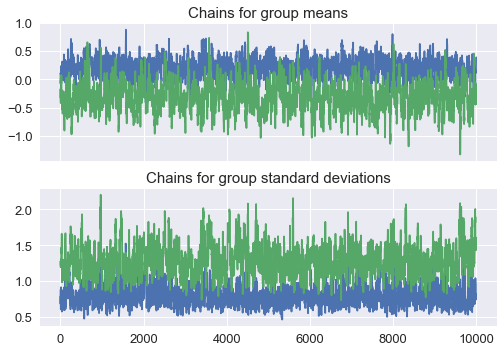

In [23]:
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True)
axes[0].plot(chain.mu);
axes[0].set_title("Chains for group means")
axes[1].plot(chain.sigma);
axes[1].set_title("Chains for group standard deviations");
fig.tight_layout()

With the posterior we get rich information about our model parameters. These posterior distributions are telling us the likely values for the parameters *given our observed data*. The means of the distributions can be used as a point estimate, but we also get a measure of the uncertainty from the width of the distribution. 

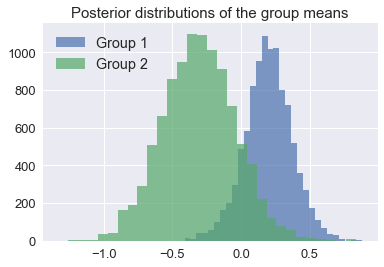

In [24]:
for each, group in zip(chain.mu.T, ['Group 1', 'Group 2']):
    plt.hist(each, alpha=0.7, bins=30, label=group);
    plt.legend(fontsize='x-large')
    plt.title("Posterior distributions of the group means")

We can answer our initial question, are these two groups different, is there an effect, by looking at the difference of the $\mu$ posteriors. With this distribution we can ask questions such as what's the probability the difference is less than than zero? We've sampled from the posterior distribution, so we can get an actual probability out for this, we just sum up the number of samples less than zero and divide by the total number of samples. We can also get an interval that contains 95% (or whatever percent) of the probability. In Bayesian statistics, this is called the **credible region**.

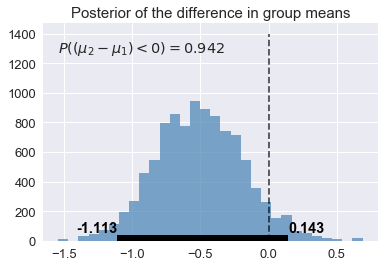

In [25]:
fig, ax = plt.subplots()
mu_diff = (chain.mu[:, 1] - chain.mu[:, 0])

ax.hist(mu_diff, bins=30, color='steelblue', alpha=0.7);
ax.set_title("Posterior of the difference in group means")

# Probability < 0?
p_lt_0 = np.mean(mu_diff < 0)
ax.vlines(0, 0, 1400, linestyles='--', alpha=0.7)
ax.text(-1.55, 1275, f"$P((\mu_2 - \mu_1) < 0) = {p_lt_0:0.3f}$", size='x-large');

# Credible region
cr = np.percentile(mu_diff, (2.5, 97.5))
ax.hlines(22, cr[0], cr[1], linewidth=6)
ax.text(cr[0]-0.3, 60, f"{cr[0]:0.3f}", weight=700, size='x-large', color='k');
ax.text(cr[1], 60, f"{cr[1]:0.3f}", weight=700, size='x-large', color='k');

For the above results (your will likely be slightly different unless you set some random seeds), we see there is a 94% probability that the difference of the means is less than 0. This is some good evidence to believe the drug has an actual effect. We also have the 95% credible region which tells us there is a 95% probability the true difference in means falls between -1.113 and 0.143.

Now we can do something more complicated, a linear model. Here I'm going to generate some fake data and fit a model to it. If everything works as we expect, we should find our model finds the true parameters of our synthetic data.

In [44]:
# First create some random data.
np.random.seed(147)
# Number of data points
N = 200
# True parameters
sigma = 1
true_B = np.array([2, 1, -3])

# Simulated features, including a constant
features = np.ones((N, len(true_B)))
features[:,1:] = np.random.rand(N, 2)

# Simulated outcomes with normally distributed noise
outcomes = np.dot(features, true_B) + np.random.randn(N)*sigma

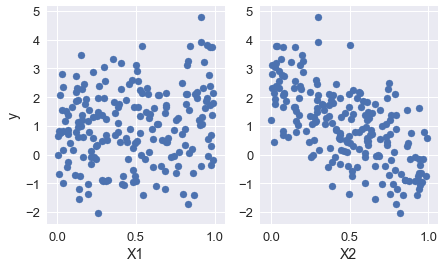

In [45]:
fig, axes = plt.subplots(figsize=(7,4),ncols=2)
for i, ax in enumerate(axes):
    ax.scatter(features[:,i+1], outcomes)
axes[0].set_ylabel('y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2');

In [35]:
class Linear(Model):
    def __init__(self, features, outcomes):
        super().__init__()
        
        self.features = features
        self.outcomes = outcomes
        
        # Linear coefficients
        self.beta = Parameter.zeros(3, 1)
        
        # likelihood parameters, prediction error
        self.sigma = Parameter([1.])
        
    def logp(self):
        predicted = torch.mm(self.features, self.beta)
        
        llh = Normal(self.outcomes, mu=predicted, sig=self.sigma)
        
        beta_prior = Uniform(self.beta, -100, 100)
        sig_prior = Uniform(self.sigma, 0., 100.)
        
        return dist_sum(llh, sig_prior, beta_prior)

In [36]:
model = Linear(Data(features), Data(outcomes).view(-1, 1))
find_MAP(model, iters=5000)
print(model.parameters)

{'beta': Parameter([[ 2.0346],
        [ 0.8827],
        [-3.0203]]), 'sigma': Parameter([0.9771])}


Our true values for the coefficients are `np.array([2, 1, -3])` which match really well with the MAP estimates we found from the model. In effect we've fit a common linear regression model and found point estimates for the model coefficients. Again though, we're Bayesianists and we are not satisfied with point estimates. We want a distribution over our parameters. We'll sample again with the Metropolis sampler.

In [37]:
sampler = Metropolis(model)
chain = sampler.sample(20000, burn=10000, thin=2)

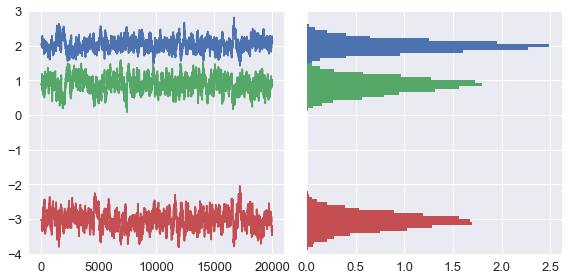

In [38]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey=True)
axes[0].plot(chain.beta);
axes[0].set_ylim(-4, 3)
for each in chain.beta.T:
    hist, bin_edges = np.histogram(each, bins=100, range=(-4, 4), density=True)
    axes[1].barh(bin_edges[:-1], hist, height=0.1)
fig.tight_layout()

Finally, we can show the means and credible regions for each coefficient.

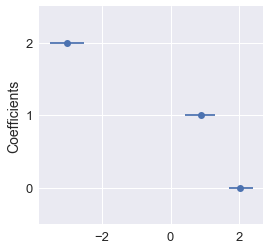

In [41]:
crs = np.percentile(chain.beta, (2.5, 97.5), axis=0)
means = chain.beta.mean(0)
fig, ax = plt.subplots(figsize=(4, 4))
ax.errorbar(means, np.arange(3), xerr=np.abs(crs-means), fmt='o')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['0', '1', '2'])
ax.set_ylabel("Coefficients")
ax.set_ylim(-0.5, 2.5);

We can also make predictions from new data. For example, if we have some new data point $x$, we'd like to infer the outcome $y$ with out model. Our model assumes the data is drawn from a normal distribution with mean $\hat{y} = \beta \cdot x$ and standard deviation $\sigma$. We'll take samples for $\beta$ and $\sigma$ from our posterior distribution, use them to define a normal distribution, then sample from that distribution to get our posterior predictive distribution. From the predictive distribution, we'll get an estimate of the infered outcome along with the uncertainty in our estimate.

In [110]:
# Our new data point
torch.random.manual_seed(124)
x = Data(torch.rand(3))

y_infer = torch.mm(torch.FloatTensor(chain.beta), x.view(3, 1))
normal = torch.distributions.normal.Normal(y_infer, torch.FloatTensor(chain.sigma))

post_predict = normal.sample((1,)).squeeze().numpy()

In [111]:
print(f'Mean: {post_predict.mean():.4f}')
print(f'95% Credible region: {np.percentile(post_predict, (2.5, 97.5))}')

Mean: -1.6656
95% Credible region: [-3.65288463  0.32670853]


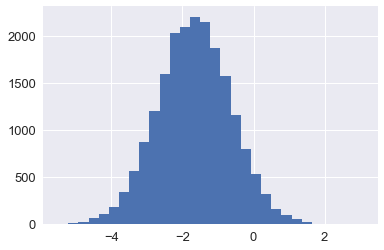

In [112]:
plt.hist(post_predict, bins=30);